# Analyse de données financières : Détection d'anomalies dans un porteuille d'actifs

In [42]:
import quandl
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn
from sklearn.ensemble import IsolationForest
from sklearn.neighbors.kde import KernelDensity

# instruction pour plotter dans notebook
%matplotlib inline

# connection à quandl via l'api key
# quandl.ApiConfig.api_key = " 3CipYF1Y3fzjvDgg7E2n"

In [43]:
# Lecture des données
# df = pd.read_csv("all_stocks_5yr.csv", index_col= [0,2],usecols=[0,4,6],parse_dates=[0])
df = pd.read_csv("all_stocks_5yr.csv",usecols=[0,4,6], parse_dates=[0])
df.head()
df.Date = pd.to_datetime(df.Date)
df = df.loc[(df.Date<datetime.datetime(2017, 8, 11,0,0,0)),:]
df = df.loc[df.Date>datetime.datetime(2015, 8, 11,0,0,0),:]
#df =df.dropna(axis=0, how='all').dropna(axis=1, how='any').dropna(axis=0, how='any')
#df.loc[df.Name=='MMM',:]

In [44]:
# df sans index devient un df avec index
# df_mi = df.set_index(['Name','Date'])

In [45]:
# On récupère les donnée sur deux ans, les données principales sont des données sur cinq ans


In [46]:
# on unstack le multi index pour en faire un 
# df_unstack = df_mi.unstack(level=0)
#df_unstack

## Rendements

In [47]:
# fonction de calcul de rendement
# def rends(dff):
#    return dff/dff.diff(1) - 1


In [48]:
# Rendements journaliers obtenue à partit d'un tableau dynamique
df_rendements = df.pivot('Date', 'Name', 'Close').pct_change() #.reset_index(level=[0]).set_index(['Date'])

In [49]:
# fontion de calcul de moyenne mobile sur le rendement
def rends_moov(dff):
    return dff.rolling(window =40).mean()

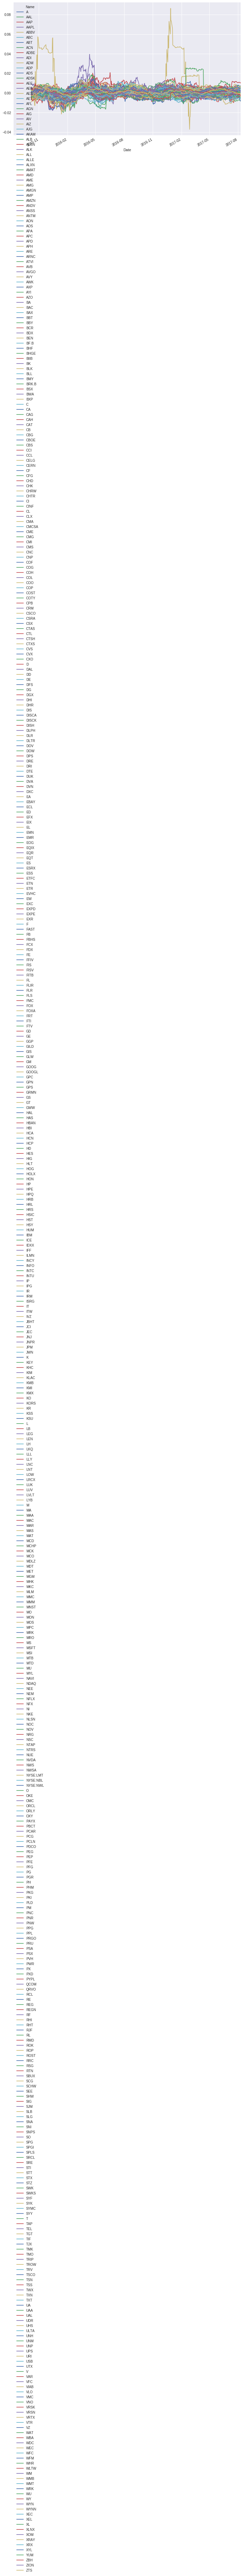

In [50]:
# Calculate the moving average sur les rendements
df_moving_rendements = df_rendements.apply(rends_moov)
df_moving_rendements.plot(figsize=(12,8))

## Volatilités

In [51]:
#fonction de calcul des volatilités sur une période
def volts(dff):
    return dff.rolling(40).std() * np.sqrt(40) 

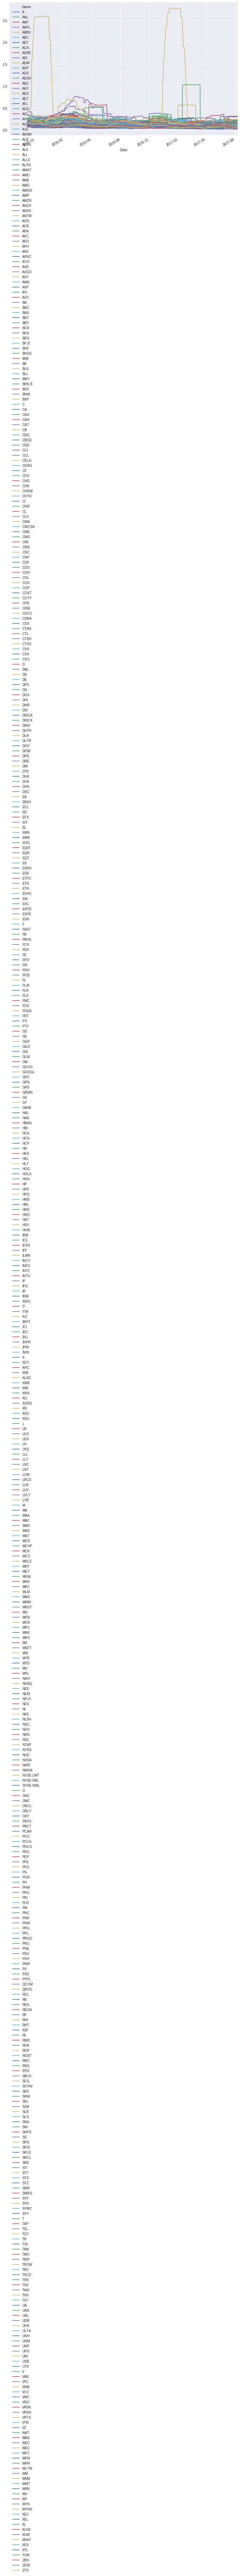

In [52]:
# Define the minumum of periods to consider 
# min_periods = 75
df_moving_volts = df_rendements.apply(volts)
df_moving_volts.plot(figsize=(12,8))

# Detection d'anomalies

# Détection sur les rendements

In [53]:
# df_2 est de dataframe qui contient les données dont on doit détecter les anomalies
# Applications de l'isolation forest sur les données de rendements ou de volatilités
clf = IsolationForest(n_estimators=100, max_samples='auto')

# fit de l'estimateur
clf.fit(df_moving_rendements.transpose().dropna(axis=0, how='all').dropna(axis=1, how='any'))

# the anomaly score of the input samples. the lower the more abnormal.
scores_pred = pd.DataFrame(clf.decision_function(df_moving_rendements.transpose().dropna(axis=0, how='all').dropna(axis=1, how='any')),index=df_moving_rendements.transpose().dropna(axis=0, how='all').dropna(axis=1, how='any').index.values)

predictions = pd.DataFrame(clf.predict(df_moving_rendements.transpose().dropna(axis=0, how='all').dropna(axis=1, how='any')), index=df_moving_rendements.transpose().dropna(axis=0, how='all').dropna(axis=1, how='any').index.values)

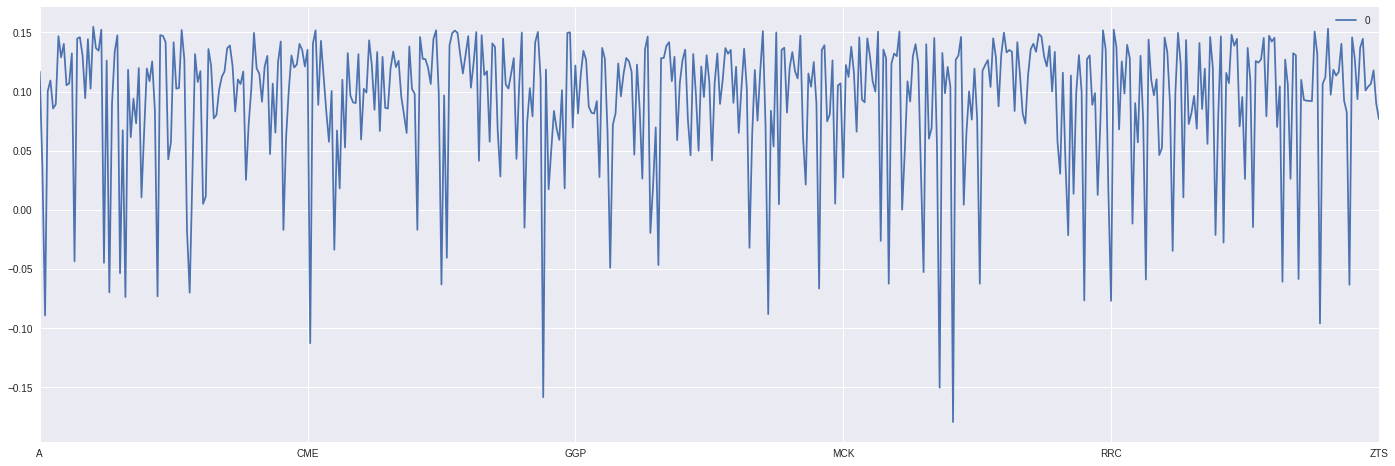

In [54]:
# Les scores de tous les individus
scores_pred.plot(figsize=(24,8))

In [55]:
# Les anomalies prédits ou détectées par le modèle
predictions[predictions==-1].dropna().transpose().columns

Index(['AAP', 'ADSK', 'AKAM', 'ALGN', 'ALXN', 'AMD', 'ANDV', 'APC', 'AYI',
       'AZO', 'BBY', 'BCR', 'CHK', 'CMG', 'COO', 'DLTR', 'DVN', 'EA', 'FCX',
       'FL', 'GWW', 'HP', 'HRB', 'KIM', 'KR', 'LB', 'M', 'MAT', 'MOS', 'MRO',
       'MTD', 'NFX', 'NRG', 'NVDA', 'NYSE:NBL', 'ORLY', 'PYPL', 'REGN', 'RL',
       'RRC', 'SIG', 'SNI', 'STX', 'SYF', 'TRIP', 'TSCO', 'ULTA', 'VIAB',
       'VRTX', 'WFM', 'XEC'],
      dtype='object')

In [56]:
# le score des anomalies
scores_pred.loc[predictions[predictions==-1].dropna().transpose().columns,:].transpose()

,AAP,ADSK,AKAM,ALGN,ALXN,AMD,ANDV,APC,AYI,AZO,...,SNI,STX,SYF,TRIP,TSCO,ULTA,VIAB,VRTX,WFM,XEC
0,-0.08913,-0.043476,-0.044707,-0.069663,-0.053498,-0.073627,0.010559,-0.073065,-0.017423,-0.069886,...,-0.058845,-0.034637,0.010569,-0.021181,-0.027565,-0.014534,-0.06067,-0.058396,-0.095893,-0.063259


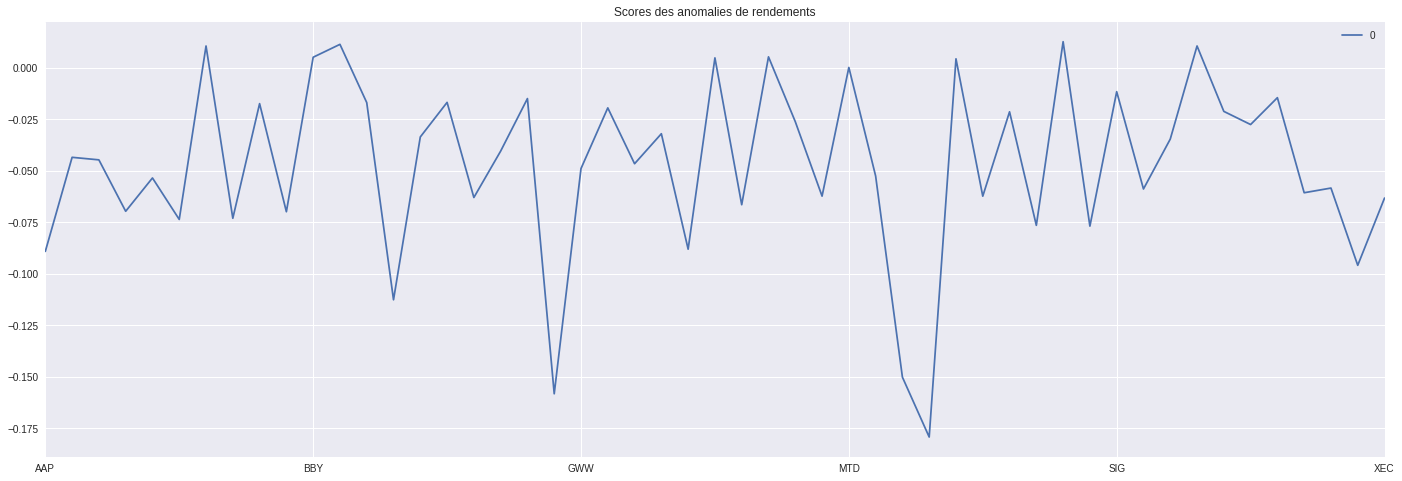

In [57]:
# le score des anomalies
scores_pred.loc[predictions[predictions==-1].dropna().transpose().columns,:].plot(figsize=(24,8), title='Scores des anomalies de rendements')

# Détection sur les volatilités

In [58]:
# df_2 est de dataframe qui contient les données dont on doit détecter les anomalies
# Applications de l'isolation forest sur les données de rendements ou de volatilités
clf = IsolationForest(n_estimators=100, max_samples='auto')

# fit de l'estimateur
clf.fit(df_moving_volts.transpose().dropna(axis=0, how='all').dropna(axis=1, how='any'))

# the anomaly score of the input samples. the lower the more abnormal.
scores_pred2 = pd.DataFrame(clf.decision_function(df_moving_volts.transpose().dropna(axis=0, how='all').dropna(axis=1, how='any')),index=df_moving_volts.transpose().dropna(axis=0, how='all').dropna(axis=1, how='any').index.values)

# 
predictions2 = pd.DataFrame(clf.predict(df_moving_volts.transpose().dropna(axis=0, how='all').dropna(axis=1, how='any')), index=df_moving_volts.transpose().dropna(axis=0, how='all').dropna(axis=1, how='any').index.values)

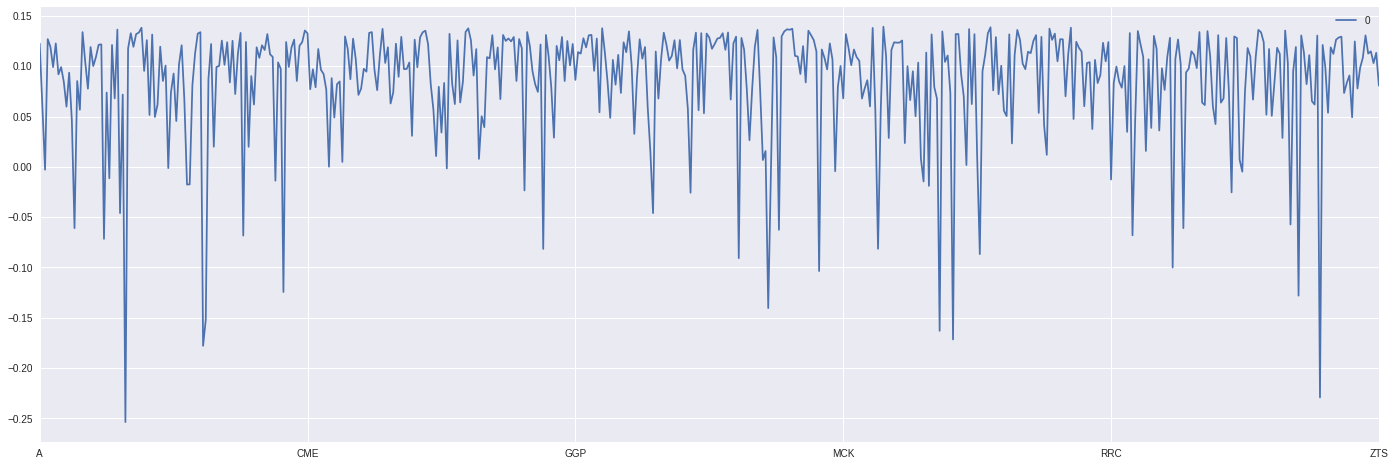

In [59]:
# Les scores de tous les individus
scores_pred2.plot(figsize=(24,8))

In [60]:
# Les anomalies prédits ou détectées par le modèle
predictions2[predictions2==-1].dropna().transpose().columns

Index(['AAP', 'ADSK', 'AKAM', 'ALGN', 'ALXN', 'AMD', 'ARNC', 'AYI', 'AZO',
       'BBY', 'BCR', 'CA', 'CF', 'CHK', 'COH', 'COTY', 'DUK', 'EA', 'EQT',
       'FCX', 'FL', 'HP', 'HPE', 'INCY', 'JWN', 'KO', 'KR', 'KSS', 'LB', 'M',
       'MAT', 'MON', 'NFLX', 'NFX', 'NKE', 'NRG', 'NVDA', 'NYSE:NWL', 'ORCL',
       'ORLY', 'PRGO', 'RRC', 'SIG', 'STX', 'SYF', 'TWX', 'UA', 'UAA', 'VNO',
       'VRTX', 'WFM'],
      dtype='object')

In [61]:
# le score des anomalies
scores_pred2.loc[predictions2[predictions2==-1].dropna().transpose().columns,:].transpose()

,AAP,ADSK,AKAM,ALGN,ALXN,AMD,ARNC,AYI,AZO,BBY,...,RRC,SIG,STX,SYF,TWX,UA,UAA,VNO,VRTX,WFM
0,-0.002798,-0.060897,-0.07154,-0.011331,-0.045938,-0.253548,-0.001212,-0.017591,-0.017375,-0.177848,...,-0.012551,-0.068027,-0.099985,-0.060901,-0.025346,0.007151,-0.004823,-0.057238,-0.127952,-0.229133


In [62]:
# Graphique des scores des anomalies

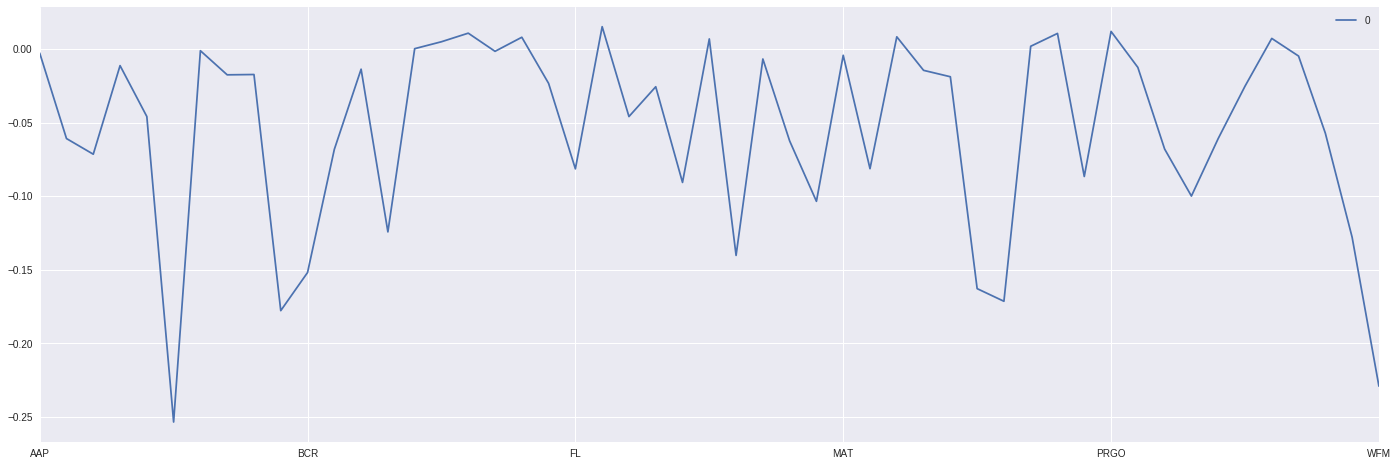

In [63]:
scores_pred2.loc[predictions2[predictions2==-1].dropna().transpose().columns,:].plot(figsize=(24,8))

In [64]:
# comparaison anomalies obetues selon le rendements vs selon la volatilité afin de comparer quelle sont détectées dans les deux cas
predictions2[predictions2==-1].dropna().transpose().columns.sort_values()==predictions[predictions==-1].dropna().transpose().columns.sort_values()

array([ True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False], dtype=bool)

# Détection sur la fonction de densité

In [65]:
# fonction d'estimation des fonction de densités des rendements des actifs
def fdensite(X):
    X_plot = np.linspace(-5, 10, 504)[:, np.newaxis]
    return np.exp(KernelDensity(kernel='gaussian', bandwidth=0.75).fit(X.dropna().values.reshape(-1, 1)).score_samples(X_plot))

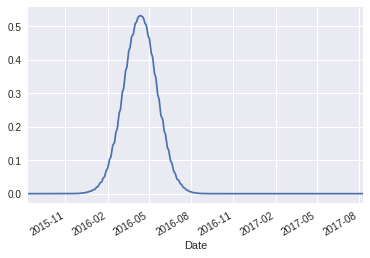

In [66]:
df_densites = df_rendements.apply(fdensite)
df_densites.to_csv('df_densite.csv')
df_densites.A.plot()

In [67]:
# df_2 est de dataframe qui contient les données dont on doit détecter les anomalies
# Applications de l'isolation forest sur les données de rendements ou de volatilités
clf = IsolationForest(n_estimators=100, max_samples='auto')

# fit de l'estimateur
clf.fit(df_densites.transpose())

# the anomaly score of the input samples. the lower the more abnormal.
scores_pred3 = pd.DataFrame(clf.decision_function(df_densites.transpose()),index=df_densites.transpose().index.values)

# 
predictions3 = pd.DataFrame(clf.predict(df_densites.transpose()), index=df_densites.transpose().index.values)

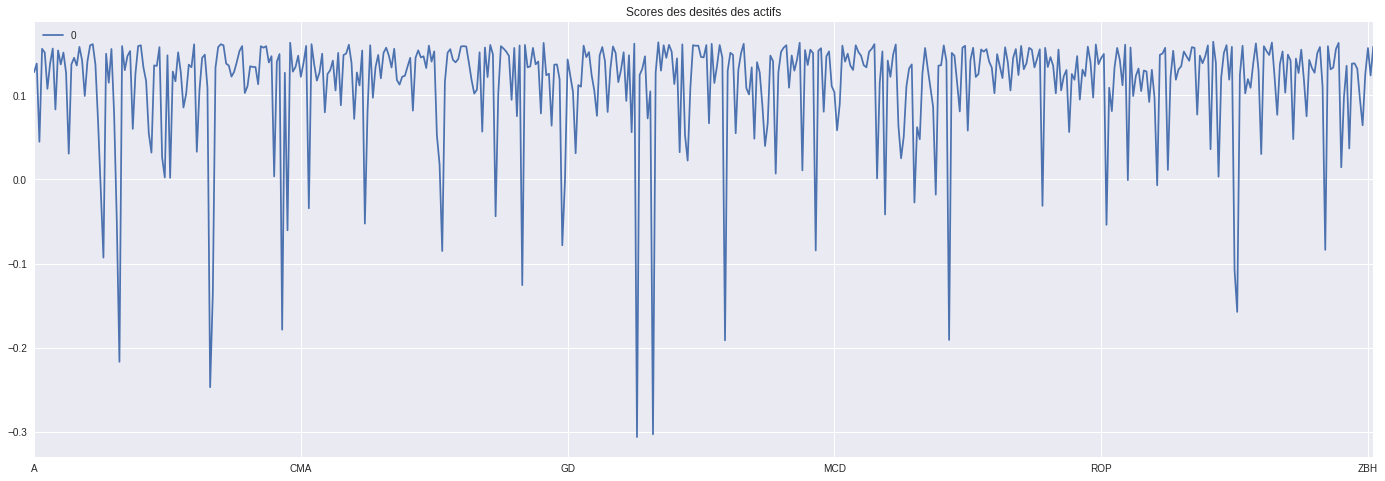

In [68]:
# Les scores de tous les individus
scores_pred3.plot(figsize=(24,8), title='Scores des desités des actifs')

In [69]:
# Les anomalies prédites ou détectées par le modèle
predictions3[predictions3==-1].dropna().transpose().columns

Index(['ADSK', 'ALB', 'ALGN', 'AMAT', 'AMD', 'APC', 'ARNC', 'ATVI', 'AVGO',
       'BBY', 'BHF', 'BHGE', 'CF', 'CHK', 'CHTR', 'CMG', 'CTXS', 'DVN', 'DXC',
       'EVHC', 'FCX', 'FTI', 'FTV', 'GILD', 'HLT', 'HPQ', 'IDXX', 'INCY',
       'JEC', 'LB', 'LRCX', 'M', 'MOS', 'MRO', 'MU', 'NEM', 'NRG', 'NVDA',
       'PRGO', 'RRC', 'SIG', 'SRCL', 'STX', 'TRIP', 'TSCO', 'UA', 'UAA', 'URI',
       'WMB', 'WYNN', 'XL'],
      dtype='object')

In [70]:
# le score des anomalies
scores_pred3.loc[predictions3[predictions3==-1].dropna().transpose().columns,:].transpose()

,ADSK,ALB,ALGN,AMAT,AMD,APC,ARNC,ATVI,AVGO,BBY,...,SRCL,STX,TRIP,TSCO,UA,UAA,URI,WMB,WYNN,XL
0,0.030709,-0.011115,-0.092784,-0.048493,-0.216564,0.031902,0.026171,0.002367,0.001996,0.032911,...,-0.006864,0.011383,0.035967,0.003307,-0.107532,-0.157278,0.030257,-0.083593,0.014483,0.036918


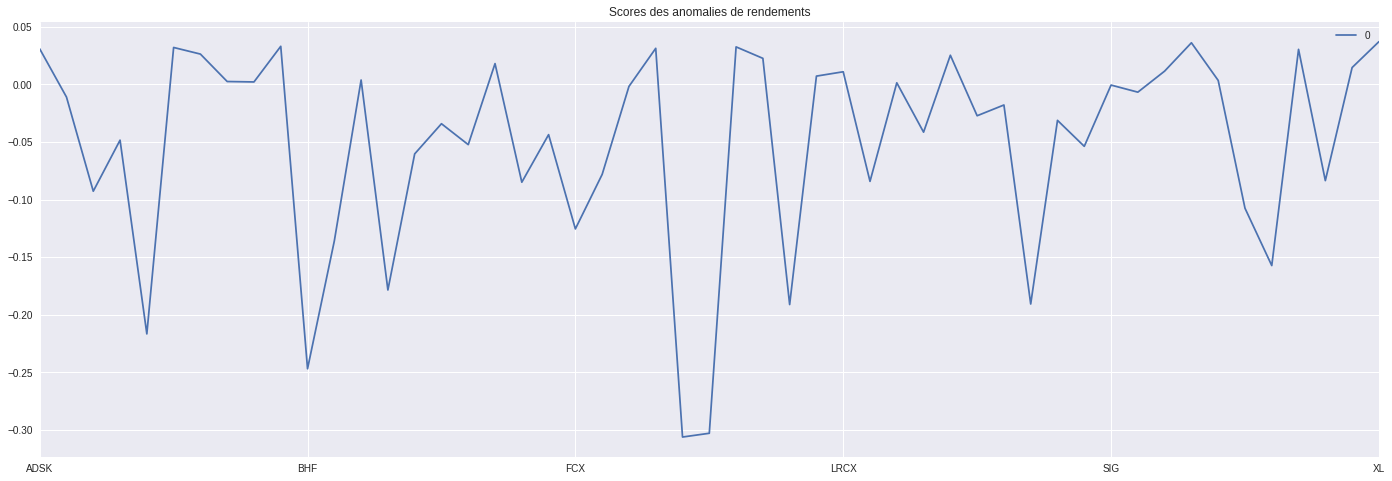

In [71]:
# le score des anomalies
scores_pred3.loc[predictions3[predictions3==-1].dropna().transpose().columns,:].plot(figsize=(24,8), title='Scores des anomalies de rendements')

# Nielson siegel svensson détection sur densité

In [72]:
#a = df_rendements.A.reset_index().A.sort_values().reset_index().A.to_csv('nss_data.csv')
a= pd.read_csv("sols.csv", index_col=0)

In [73]:
a.head()

,V1,V2,V3,V4,V5,V6
A,0.074582,29.916334,-29.999920,-0.034166,0.097919,5.0
AAL,0.074639,29.265639,-29.429360,-0.034725,0.045010,5.0
AAP,0.074583,29.916275,-29.999859,-0.034171,0.097909,5.0
AAPL,0.074639,28.937917,-29.148916,-0.034724,0.034924,5.0
ABBV,0.074583,29.794237,-29.877787,-0.034170,0.097941,5.0


In [74]:
# df_2 est de dataframe qui contient les données dont on doit détecter les anomalies
# Applications de l'isolation forest sur les données de rendements ou de volatilités
clf = IsolationForest(n_estimators=100, max_samples='auto')

# fit de l'estimateur
clf.fit(a)

# the anomaly score of the input samples. the lower the more abnormal.
scores_pred4 = pd.DataFrame(clf.decision_function(a),index=a.index.values)

# 
predictions4 = pd.DataFrame(clf.predict(a), index=a.index.values)

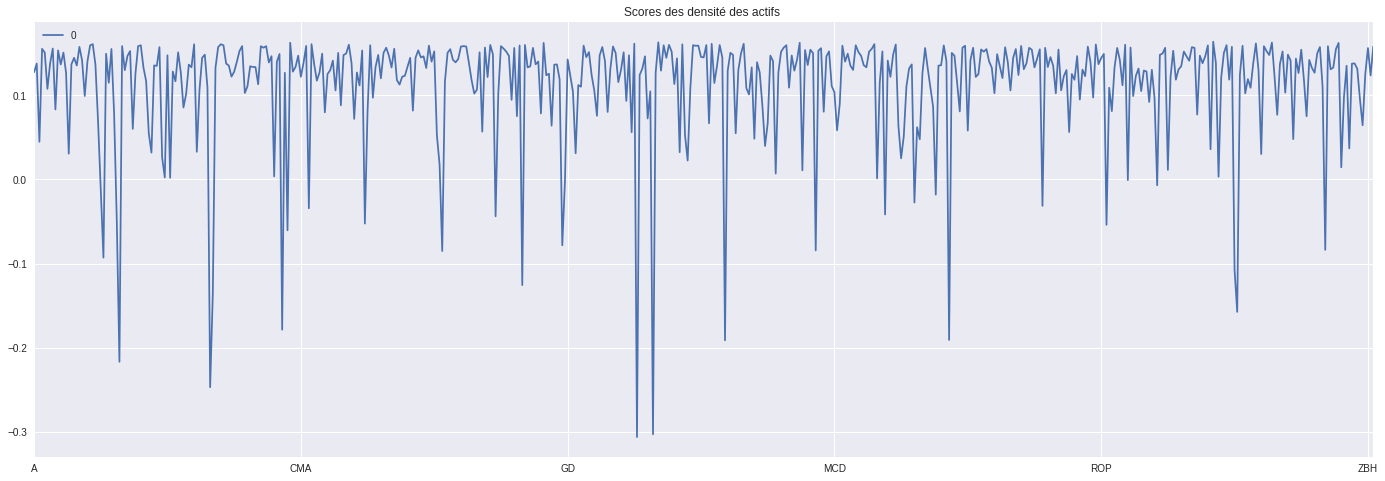

In [75]:
# Les scores de tous les individus
scores_pred3.plot(figsize=(24,8), title='Scores des densité des actifs ')

In [76]:
# Les anomalies prédites ou détectées par le modèle
predictions4[predictions4==-1].dropna().transpose().columns

Index(['ADM', 'AFL', 'ALL', 'APD', 'AVGO', 'AVY', 'BHF', 'BHGE', 'BK', 'BMY',
       'CA', 'CB', 'CHK', 'CME', 'CSX', 'DRE', 'DVN', 'ETN', 'EXC', 'FISV',
       'FOXA', 'GILD', 'GRMN', 'HLT', 'HPQ', 'JNJ', 'KSU', 'LB', 'LEG', 'M',
       'MDT', 'MNST', 'MRO', 'OKE', 'ORLY', 'PAYX', 'PFE', 'PSX', 'RRC', 'SNA',
       'TMO', 'TRIP', 'TROW', 'VMC', 'VTR', 'WMB', 'WMT', 'WYNN', 'XLNX',
       'ZBH', 'ZION'],
      dtype='object')

In [77]:
predictions3[predictions3==-1].dropna().transpose().columns

Index(['ADSK', 'ALB', 'ALGN', 'AMAT', 'AMD', 'APC', 'ARNC', 'ATVI', 'AVGO',
       'BBY', 'BHF', 'BHGE', 'CF', 'CHK', 'CHTR', 'CMG', 'CTXS', 'DVN', 'DXC',
       'EVHC', 'FCX', 'FTI', 'FTV', 'GILD', 'HLT', 'HPQ', 'IDXX', 'INCY',
       'JEC', 'LB', 'LRCX', 'M', 'MOS', 'MRO', 'MU', 'NEM', 'NRG', 'NVDA',
       'PRGO', 'RRC', 'SIG', 'SRCL', 'STX', 'TRIP', 'TSCO', 'UA', 'UAA', 'URI',
       'WMB', 'WYNN', 'XL'],
      dtype='object')